# RDM: Final assignment
### Gaja Nenadović

In [4]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [7]:
server = "localhost"
user = "root"
pwd = "*******" # I used local version of workbench, otherwise root for VM
schema = "TimeSeries"

In [8]:
db = pymysql.connect(host=server, user=user, password=pwd, database=schema, sql_mode='')
db.db

b'TimeSeries'

In [9]:
cursor = db.cursor(pymysql.cursors.DictCursor)

In [10]:
countries = ['AT', 'BE', 'BG']
dates = ('2016-01-01', '2016-12-31')
fundament = 'load'

First, let's get the data (actuals and forecasts) between two dates for a certain fundament and country and calculate the difference between actual and forecast.

In [11]:
def load_act_for(t1, t2, fund):
    q = '''
     SELECT AVG(t3.value - fo.value) AS mean_diff, t3.country_name FROM
     (SELECT t2.value, t2.country_name, t2.timestamp, f.fund_name, t2.country_id, t2.time_id, f.fund_id FROM
     (SELECT t1.value, t1.country_name, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
     (SELECT a.value, c.country_name, a.time_id, a.fund_id, a.country_id
     FROM TimeSeries.Actual AS a 
     INNER JOIN TimeSeries.Country AS c
     ON a.country_id = c.country_id) as t1
     INNER JOIN TimeSeries.Time as t 
     ON t.time_id = t1.time_id 
     WHERE (t.timestamp BETWEEN '{}' AND '{}')) AS t2
     INNER JOIN TimeSeries.Fundament as f 
     ON f.fund_id = t2.fund_id WHERE fund_name = '{}') AS t3
     INNER JOIN TimeSeries.Forecast AS fo
     ON fo.time_id = t3.time_id AND fo.country_id = t3.country_id AND fo.fund_id = t3.fund_id
     GROUP BY country_name
    '''.format(t1, t2, fund)
    df = pd.read_sql(q, db)
    return(df)

In [12]:
d = load_act_for(*dates, fundament)

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [13]:
d

,mean_diff,country_name
0,-100.779021,AT
1,123.135973,BE
2,-9.738614,BG


What is the average difference between actual and forecasted load per country between January 1st and December 31st in 2016?

- AT: -100.8
- BE: 123.1
- BG: -9.7

As we can see, the forecasts for load in 2016 are on average the most accurate for BG and the least for BE. For AT and BG, forecasts underestimate the load, while for BE they overestimate it.

What is the trend in average yearly temperature between 1980 and 2020 per country?

In [9]:
def yearly_trend(fund):   
    q = '''
     SELECT AVG(t2.value) AS mean, t2.country_name, YEAR(t2.timestamp) AS year FROM
     (SELECT t1.value, t1.country_name, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
     (SELECT a.value, c.country_name, a.time_id, a.fund_id, a.country_id
     FROM TimeSeries.Actual AS a 
     INNER JOIN TimeSeries.Country AS c
     ON a.country_id = c.country_id) as t1
     INNER JOIN TimeSeries.Time as t 
     ON t.time_id = t1.time_id) AS t2
     INNER JOIN TimeSeries.Fundament as f 
     ON f.fund_id = t2.fund_id WHERE fund_name = '{}'
     GROUP BY t2.country_name, YEAR(t2.timestamp)
    '''.format(fund)
    return(pd.read_sql(q, db))

In [10]:
df = yearly_trend('temperature')

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Let's plot the trends.

In [17]:
def plot_avgs(arr, labels, f, a, cntry, xlabel='Year', ylabel='Mean hourly temperature', title='Mean T per year and country'):
    x = np.arange(0, len(labels))
    a.plot(x, arr, '-o', label=cntry)
    a.set_xticklabels(labels=list(labels), rotation=90)
    a.set_xticks(x)
    a.set_title(title, size=22)
    a.set_xlabel(xlabel, size=15)
    a.set_ylabel(ylabel, size=15, rotation=90)
    a.legend()

C:\Users\Gaja\AppData\Local\Temp\ipykernel_15992\265034121.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(labels=list(labels), rotation=90)


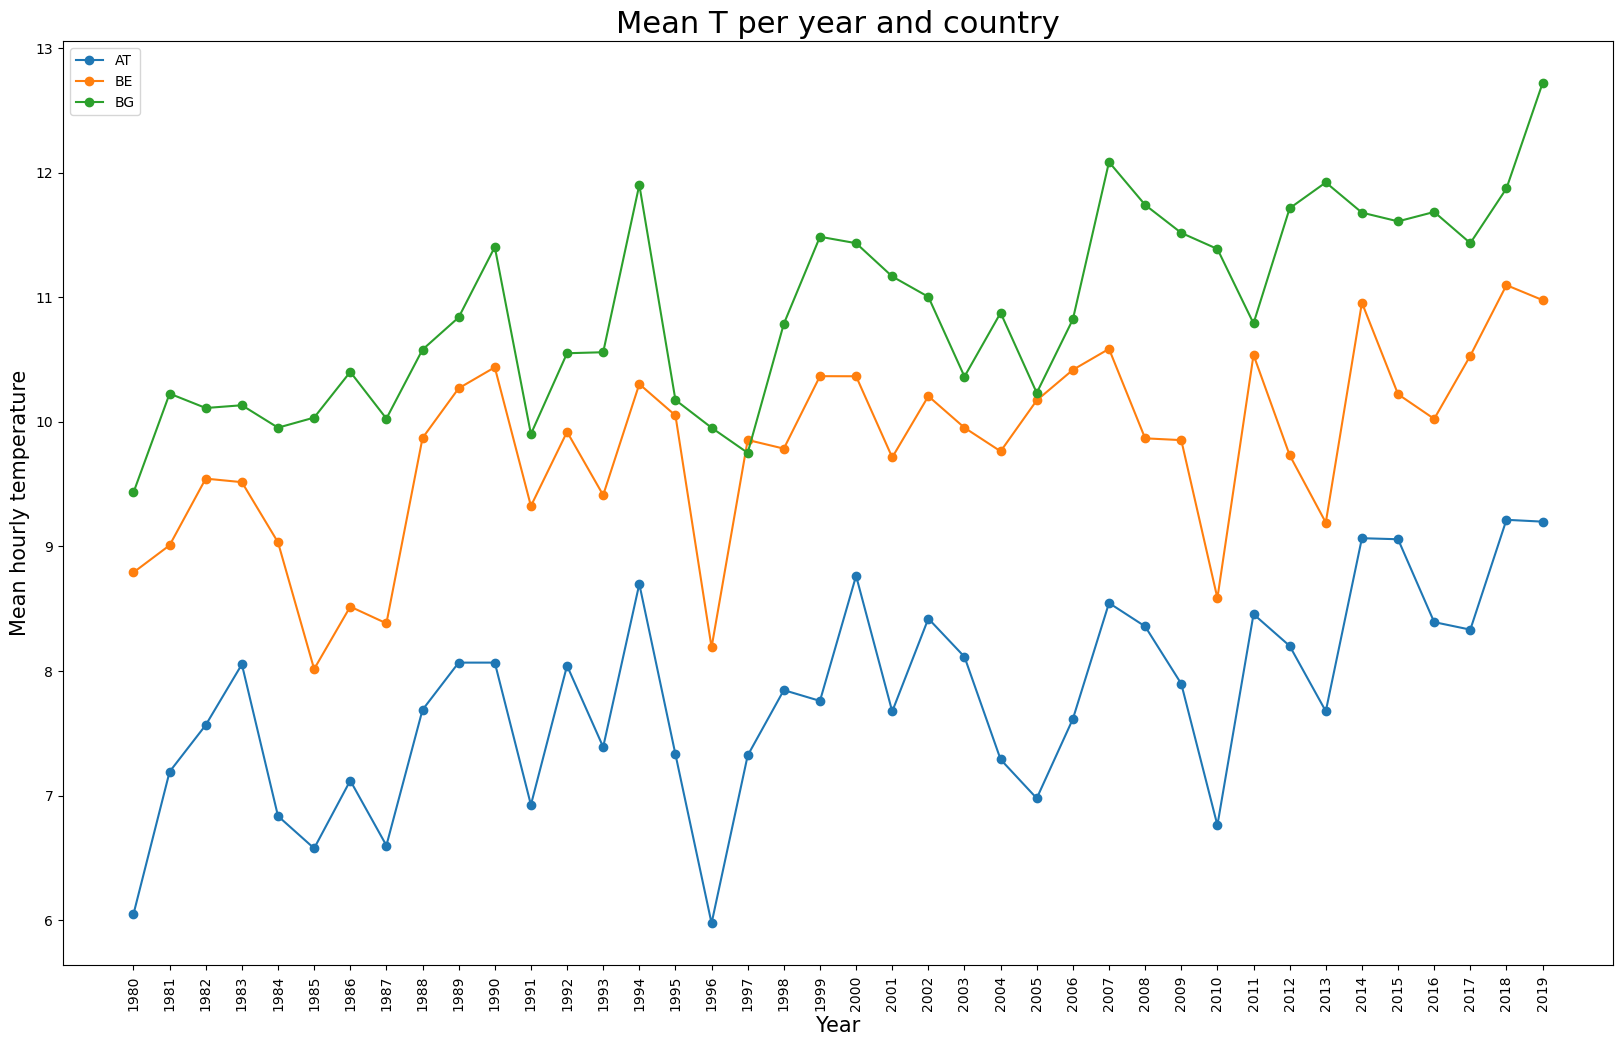

In [18]:
fig, ax = plt.subplots(figsize=(20, 12))
for c in countries:
    plot_avgs(df.loc[df['country_name'] == c]['mean'].values, list(map(str, range(1980, 2020))), f=fig, a=ax, cntry=c)

plt.show()

As we can see from the plot, global warming is real, i.e. there is a clear upwards trend in average yearly temperature in different parts of Europe, but there is some volatility present nevertheless (e.g. a sharp drop in 1996).

BG has overall the highest temperature over all 4 decades and At the lowest.

What is the average temperature for countries starting with letter B between 1980-2020?

In [19]:
def mean_fund_cntry(fund, startStr):
    q = '''
     SELECT AVG(t2.value) AS m_actual_temp, t2.country_name FROM
     (SELECT t1.value, t1.country_name, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
     (SELECT a.value, c.country_name, a.time_id, a.fund_id, a.country_id
     FROM TimeSeries.Actual AS a 
     INNER JOIN TimeSeries.Country AS c
     ON a.country_id = c.country_id) as t1
     INNER JOIN TimeSeries.Time as t 
     ON t.time_id = t1.time_id) AS t2
     INNER JOIN TimeSeries.Fundament as f 
     ON f.fund_id = t2.fund_id WHERE fund_name = '{}' 
     GROUP BY t2.country_name HAVING t2.country_name LIKE '{}%'
    '''.format(fund, startStr)
    return pd.read_sql(q, db)

In [20]:
mean_fund_cntry('temperature', 'B')

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,m_actual_temp,country_name
0,9.783023,BE
1,10.905615,BG


At which interval do the measurements of temperature become independent and are there differences between countries?

In [34]:
def ts_intervals(t1, t2, fund, cntry):
    q = '''
     SELECT t2.value AS actual_temp FROM
     (SELECT t1.value, t1.country_name, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
     (SELECT a.value, c.country_name, a.time_id, a.fund_id, a.country_id
     FROM TimeSeries.Actual AS a 
     INNER JOIN TimeSeries.Country AS c
     ON a.country_id = c.country_id WHERE c.country_name = '{}') as t1
     INNER JOIN TimeSeries.Time as t 
     ON t.time_id = t1.time_id WHERE (t.timestamp BETWEEN '{}' AND '{}')) AS t2
     INNER JOIN TimeSeries.Fundament as f 
     ON f.fund_id = t2.fund_id WHERE fund_name = '{}'
    '''.format(cntry, t1, t2, fund)
    return(pd.read_sql(q, db))

Let's plot autocorrelations for the hourly temperature actuals to determine an interval per country and compare them.

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


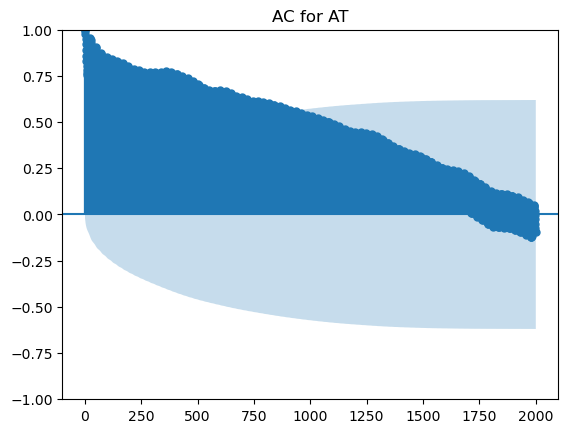

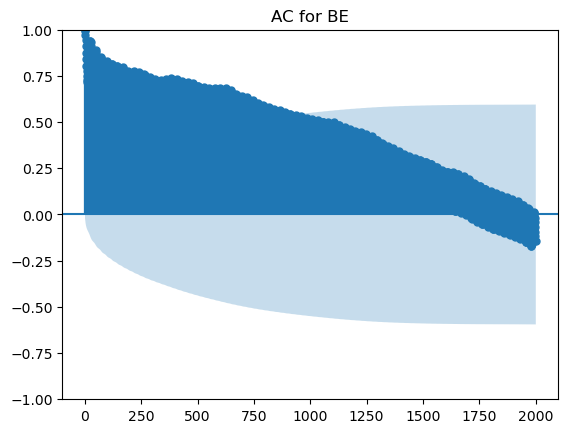

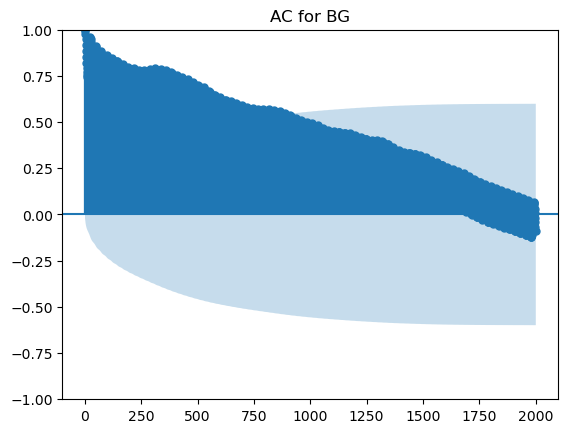

In [40]:
for c in countries:
    plot_acf(ts_intervals(*dates, 'temperature', c), lags=2000, title='AC for {}'.format(c))

As we can see, AC remain very high for a long time and they are comparable across countries. We can say that AC at the interval of app. 1600 hours (app 66 day, so more than 2 months) become independent and are within 95% CI.

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


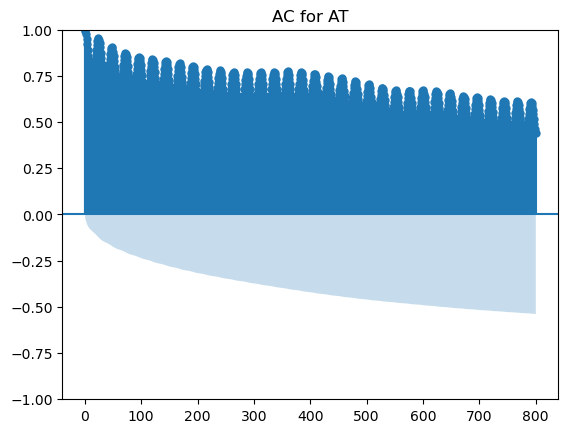

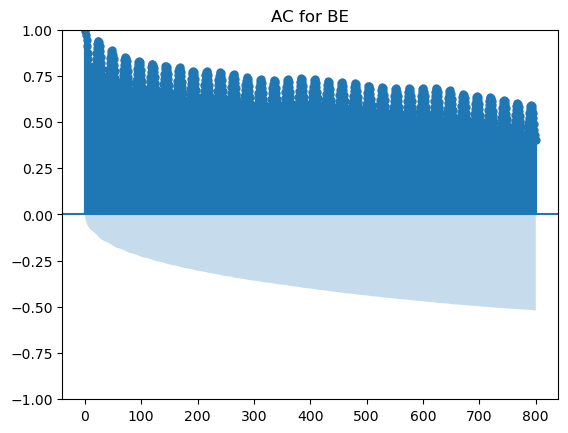

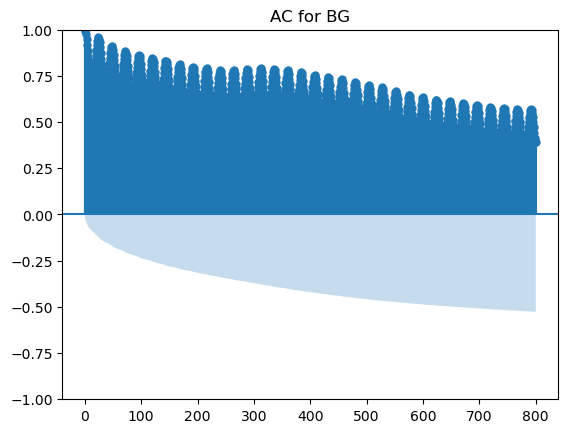

In [43]:
for c in countries:
    plot_acf(ts_intervals(*dates, 'temperature', c), lags=800, title='AC for {}'.format(c))

We also observe 24 hours periodicity and somewhat higher correlations for BG (the highest, but still comparable). If we plotted the data for a year or two, we'd observe also seasonal periodicity.

In [23]:
def high_pop(fund):
    q = '''
    SELECT t2.country_name as cntry FROM
    (SELECT t1.value, t1.country_name, t1.population, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
    (SELECT a.value, c.country_name, c.population, a.time_id, a.fund_id, a.country_id
    FROM TimeSeries.Actual AS a 
    INNER JOIN TimeSeries.Country AS c
    ON a.country_id = c.country_id) as t1
    INNER JOIN TimeSeries.Time as t 
    ON t.time_id = t1.time_id) AS t2
    INNER JOIN TimeSeries.Fundament as f 
    ON f.fund_id = t2.fund_id WHERE fund_name = '{}'
    GROUP BY t2.country_name 
    ORDER BY AVG(t2.value)/t2.population DESC
    LIMIT 1
    '''.format(fund)
    return(pd.read_sql(q, db))

In [24]:
high_pop('load')

,cntry
0,BE


Belgium has the highest average load over all 4 decades relative to its current population.

In [28]:
def highest_year(fund):
    q = '''
    WITH rank_added AS (
    SELECT *,ROW_NUMBER() OVER (PARTITION BY cntry ORDER BY mean DESC) AS rn
    FROM (SELECT AVG(t2.value) AS mean, t2.country_name as cntry, YEAR(t2.timestamp) as y FROM
    (SELECT t1.value, t1.country_name, t.timestamp, fund_id, t.time_id, t1.country_id FROM 
    (SELECT a.value, c.country_name, a.time_id, a.fund_id, a.country_id
    FROM TimeSeries.Actual AS a 
    INNER JOIN TimeSeries.Country AS c
    ON a.country_id = c.country_id) as t1
    INNER JOIN TimeSeries.Time as t 
    ON t.time_id = t1.time_id) AS t2
    INNER JOIN TimeSeries.Fundament as f 
    ON f.fund_id = t2.fund_id WHERE fund_name = '{}'
    GROUP BY t2.country_name, YEAR(t2.timestamp)) AS t3
    )
    SELECT cntry, y FROM rank_added
             WHERE rn = 1;
    '''.format(fund)
    return(pd.read_sql(q, db))

In [29]:
highest_year('load')

C:\Users\Gaja\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,cntry,y
0,AT,2018
1,BE,2015
2,BG,2017


The table shows the year with the highest actual load per country.